In [26]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import emcee
from scipy.stats import uniform
from emcee.moves import GaussianMove
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.gaussian_process.kernels import WhiteKernel
import joblib
import os
from joblib import load

In [27]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Data\Updateddata.txt",names = columns)
datatab
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

# First Mass
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))

# Second Mass
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))

# Third Mass
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))

# Fourth Mass
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

indices = np.arange(X.shape[0])
X_trainval, X_test, D_trainval, D_test, E_trainval, E_test, indices_trainval, indices_test = train_test_split(X, D,E,indices, test_size=0.1, random_state=42)
folds = 10

In [28]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)
ExpSinelbounds = (1e-2, 10.0)
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-2, 20)
nu = 1.75
nu2 = 0.75
alpha = 1
periodicity = 2
periodictybounds = (1, 20)
gamma = 1
noise_init = 1
noise_bounds = (1e-6, 1e6)
Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)
WhiteMatkernel = Matkernel + WhiteKernel(noise_level=noise_init, noise_level_bounds=noise_bounds)
Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) *RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle,alpha_bounds=(0.1,50))   ####RationalQuadraticARD(lengths=np.array([1,1,1,1]))
ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=ExpSinelbounds)
Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, gamma_bounds=(0.1,50), metric='laplacian')
RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)
RBFMatkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=(1,1,1,1), length_scale_bounds=(0.5,100)) + C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=(0.1,0.1,0.1,0.1), length_scale_bounds=(1e-6,4), nu=0.75)
RBFRadkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=(1,1,1,1), length_scale_bounds=(0.5,100)) + C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle,alpha_bounds=(0.01,0.5))   #####RationalQuadraticARD(lengths=np.array([0.1,0.1,0.1,0.1]), alpha = 0.2,lengths_bounds=(1e-6,4),alpha_bounds=(0.01,0.5))
RBFLaplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=(1,1,1,1), length_scale_bounds=(0.5,100)) + C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=1, gamma_bounds = (0.5,5),metric='laplacian')


In [49]:
kernel_name = "RBFMat"
base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'
model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
gpr_loaded = load(model_path)
params = []
for j in range(10):
    params.append(np.exp(gpr_loaded.kernel_.theta[j]))
print(f"Point estimates with Matern Kernel = {params}")
log_likelihood = gpr_loaded.log_marginal_likelihood(np.log(params))  # Take the log of params
print(f"Log likelihood of the parameters: {log_likelihood}")

Point estimates with Matern Kernel = [2.3337829033770054, 1.0, 1.5116912271601903, 1.3823143657572485, 1.3551101011779998, 0.20738097551311013, 0.09958218312780552, 0.05815785083199085, 0.4143871743144238, 2.314233135841794]
Log likelihood of the parameters: 128.39191813385173


In [ ]:
np.random.seed(42)
def log_prior(theta):
    return np.sum(uniform(loc=1e-6, scale=10).logpdf(theta))

def log_posterior(theta,gpr):

    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)

    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf
    return lp + ll
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  
guess_lmult = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
### Get point estimate for initial starting point MCMC
### Running MCMC algo

np.random.seed(42)
ndim = len(params)
nwalkers = ndim*4 
mean = np.array(params)
cov_matrix = np.diag(np.array(params))
### Where we start sampling. I take the absolute value here because I want my parameters to be positive
initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers)) 
#### getting rid of 0 values
initial_pos = np.clip(initial_pos, 1e-6, None)
cov = 1e-3
### try cov = 1e-2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args= (gpr_loaded,),moves = GaussianMove(cov=cov))
nsteps = 500
samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

acceptance_fraction = sampler.acceptance_fraction
burnin = 100
thin = 15

# Save the samples to a .pkl file using joblib
#joblib.dump(sampler.get_chain(discard=burnin, thin=thin,flat=True), 'mcmc_RBFMatern_samples.pkl')
joblib.dump(sampler.get_chain(flat=True), 'mcmc_RBFMatern_samples.pkl')

print(f"acceptance fraction = {acceptance_fraction.mean()}")

  0%|          | 2/500 [00:14<58:12,  7.01s/it]  

In [53]:
from scipy.stats import gaussian_kde
peak_values = []
#### add back in discard and thin
flat_samples = sampler.get_chain(flat=True)
for i in range(ndim):
    samples_i = flat_samples[:, i]
    kde = gaussian_kde(samples_i)  
    x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
    density = kde(x_range)
    #plt.figure()
    #plt.plot(x_range, density, 
    #     color='gray', linewidth=2.5)
    peak = x_range[np.argmax(density)]
    peak_values.append(peak)
print("Peak values for each parameter:", peak_values)

Peak values for each parameter: [2.6662992575787783, 0.35808347571253196, 1.5909477105827827, 0.3915229228436788, 0.6267701299433327, 0.25586344343002904, 0.11777054391258236, 0.11135078870967476, 0.5829310429878902, 2.3119081788854245]


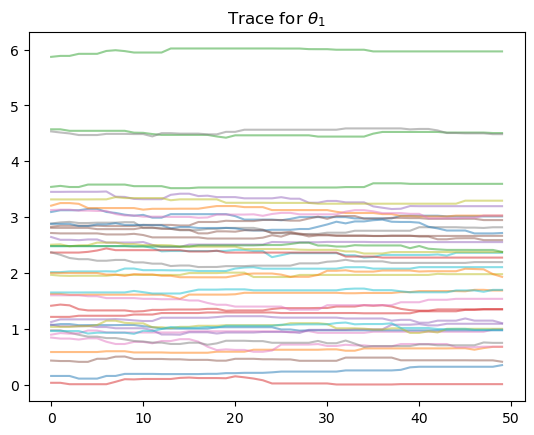

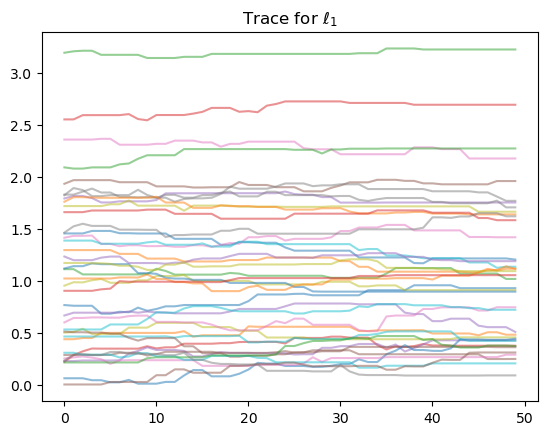

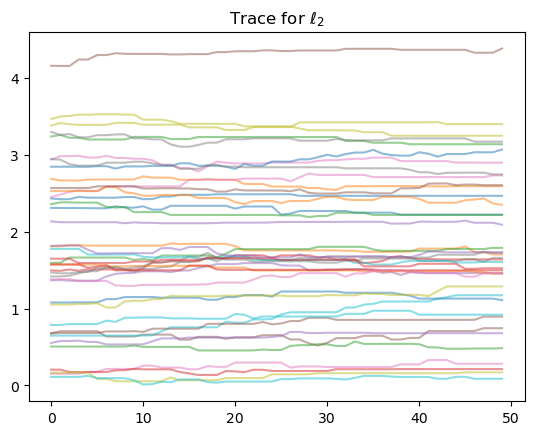

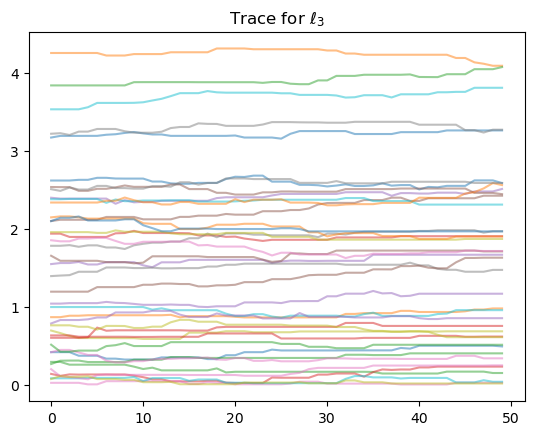

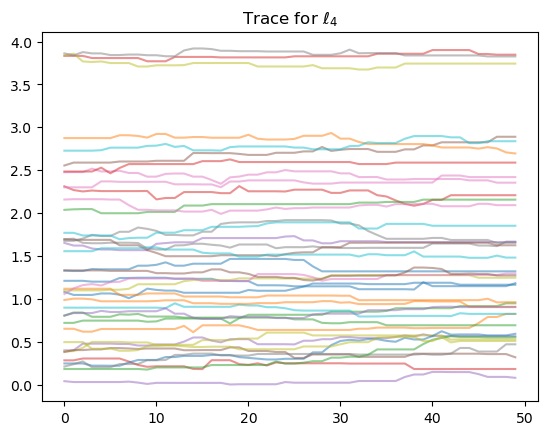

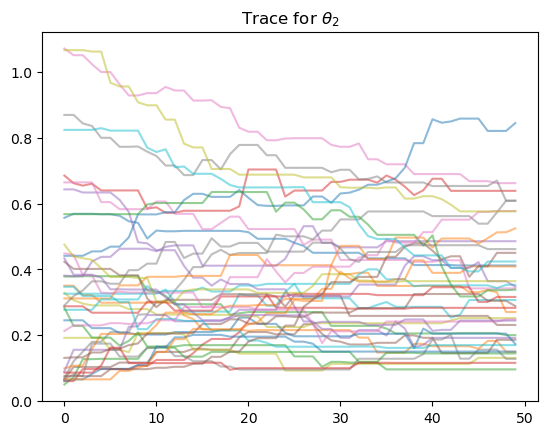

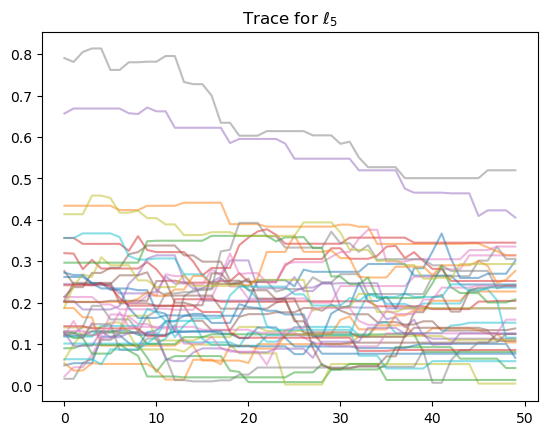

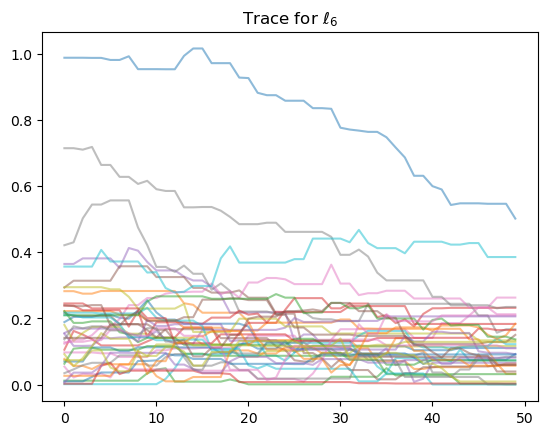

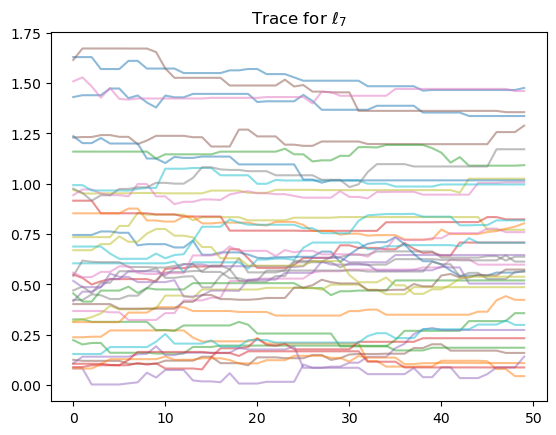

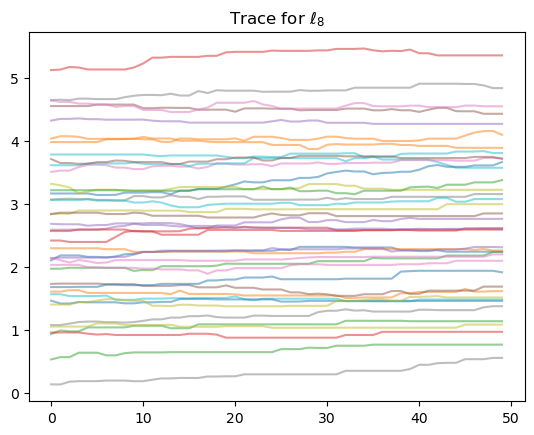

In [54]:
samples = sampler.get_chain()
param_labels = ["$\\theta_1$", "$\\ell_1$", "$\\ell_2$", "$\\ell_3$", "$\\ell_4$",
                "$\\theta_2$", "$\\ell_5$", "$\\ell_6$", "$\\ell_7$","$\\ell_8$"]

for i in range(ndim):
    plt.figure()
    for walker in range(nwalkers):
        plt.plot(samples[:, walker, i], alpha=0.5)
    plt.title(f"Trace for {param_labels[i]}")


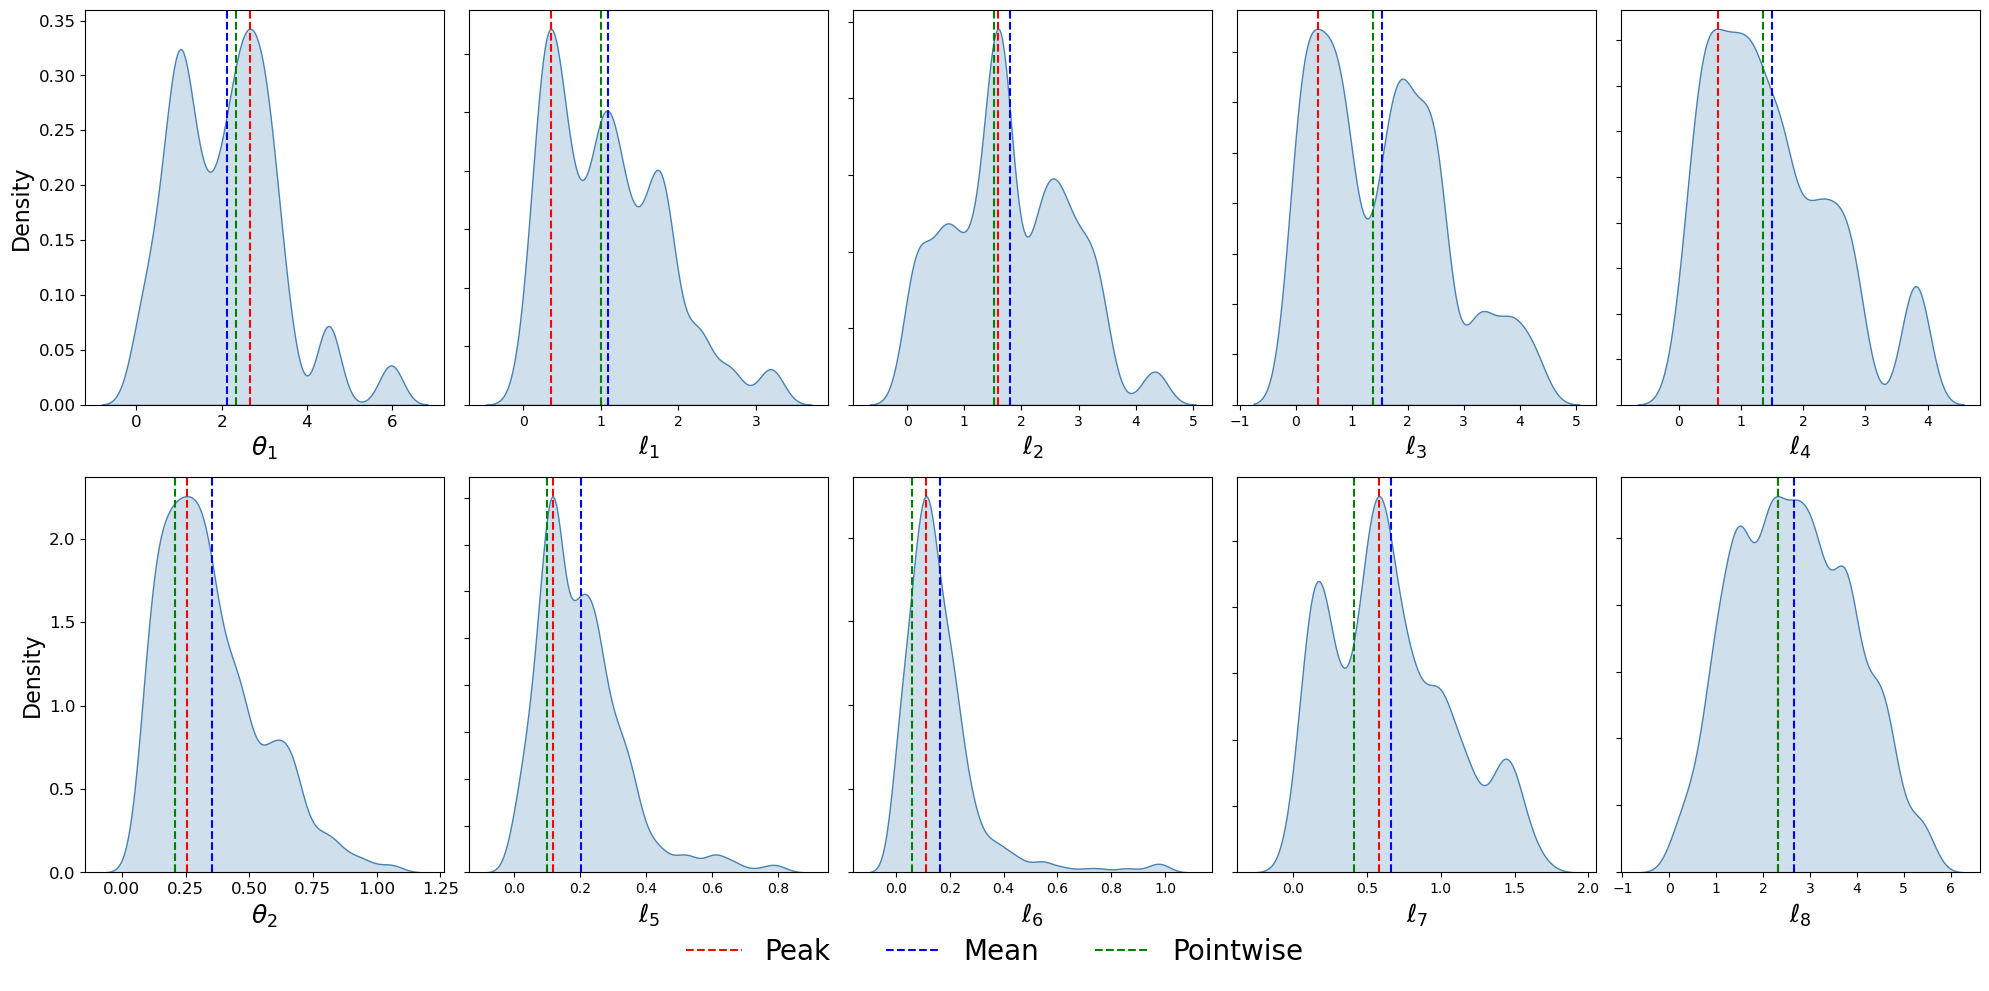

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flattened MCMC samples
flat_samples = sampler.get_chain(flat=True)
mean_values = np.mean(flat_samples, axis=0)

# Parameter labels
param_labels = ["$\\theta_1$", "$\\ell_1$", "$\\ell_2$", "$\\ell_3$", "$\\ell_4$",
                "$\\theta_2$", "$\\ell_5$", "$\\ell_6$", "$\\ell_7$","$\\ell_8$"]

# Create subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# Line handles for shared legend
line_handles = []

for i in range(10):
    sns.kdeplot(flat_samples[:, i], fill=True, ax=axes[i], color='steelblue')
    axes[i].set_xlabel(param_labels[i], fontsize=18)
    
    line1 = axes[i].axvline(peak_values[i], color="red", linestyle="--", label='Peak')
    line2 = axes[i].axvline(mean_values[i], color="blue", linestyle="--", label='Mean')
    line3 = axes[i].axvline(params[i], color="green", linestyle="--", label='Pointwise')

    if i == 0:
        line_handles = [line1, line2, line3]

    if i % 5 == 0:
        axes[i].set_ylabel("Density", fontsize=16)
    else:
        axes[i].set_ylabel("")
    
    axes[i].set_yticklabels([]) if i % 5 != 0 else axes[i].tick_params(labelsize=12)

# Shared legend placed below all plots
fig.legend(handles=line_handles, labels=['Peak', 'Mean', 'Pointwise'], 
           loc='lower center', fontsize=20, ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend
plt.show()



In [ ]:
def log_prior(theta):
    return np.sum(uniform(loc=0.01, scale=4.99).logpdf(theta))

def log_posterior(theta,gpr):

    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)

    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf

    return lp + ll
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  
guess_lmult = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
### Get point estimate for initial starting point MCMC
gpr1 = GaussianProcessRegressor(kernel=WhiteMatkernel, alpha=E_trainval**2,normalize_y=True, n_restarts_optimizer=10,random_state=42)
gpr1.fit(X_trainval, D_trainval)
#Dfit, Dstd = gpr1.predict(X1, return_std=True)
#Dtestfit,Dteststd = gpr1.predict(X1_test, return_std=True)
params = []
for j in range(6):
    params.append(np.exp(gpr1.kernel_.theta[j]))
print(f"Point estimates with Matern Kernel = {params}")

### Running MCMC algo

np.random.seed(42)
ndim = len(params)
nwalkers = ndim*4 
mean = np.array(params)
cov_matrix = np.diag(0.5*np.array(params))
### Where we start sampling. I take the absolute value here because I want my parameters to be positive
initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers)) 
cov = 0.5
### try cov = 1e-2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args= (gpr1,),moves = GaussianMove(cov=cov))
nsteps = 100
samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

acceptance_fraction = sampler.acceptance_fraction
burnin = 100
thin = 15
#discard=burnin, thin=thin,flat=True

#joblib.dump(sampler.get_chain(discard=burnin, thin=thin,flat=True), 'mcmc_Maternnoerror_samples.pkl')
joblib.dump(sampler.get_chain(flat=True), 'mcmc_Maternnoerror_samples.pkl')

print(f"acceptance fraction = {acceptance_fraction.mean()}")

c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Point estimates with Matern Kernel = [1.1385460936629326, 0.5244199742610186, 0.4017732594810011, 1.7614943517619828, 4.853362038183826, 1.0000000000000004e-06]


  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\mh.py:58: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = new_log_probs - state.log_prob + factors
100%|██████████| 2000/2000 [46:54<00:00,  1.41s/it]

acceptance fraction = 0.006541666666666668


In [ ]:
from scipy.stats import gaussian_kde
peak_values = []
#### add back in discard and thin
#flat_samples = sampler.get_chain(discard=burnin, thin=thin,flat=True)
flat_samples = sampler.get_chain(flat=True)
for i in range(ndim):
    samples_i = flat_samples[:, i]
    kde = gaussian_kde(samples_i)  
    x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
    density = kde(x_range)
    #plt.figure()
    #plt.plot(x_range, density, 
    #     color='gray', linewidth=2.5)
    peak = x_range[np.argmax(density)]
    peak_values.append(peak)
print("Peak values for each parameter:", peak_values)

Peak values for each parameter: [0.8497526706789521, 0.31799354958860543, 0.9379162544017257, 1.5743534932757455, 5.617017511713092, 0.011038051992318132]


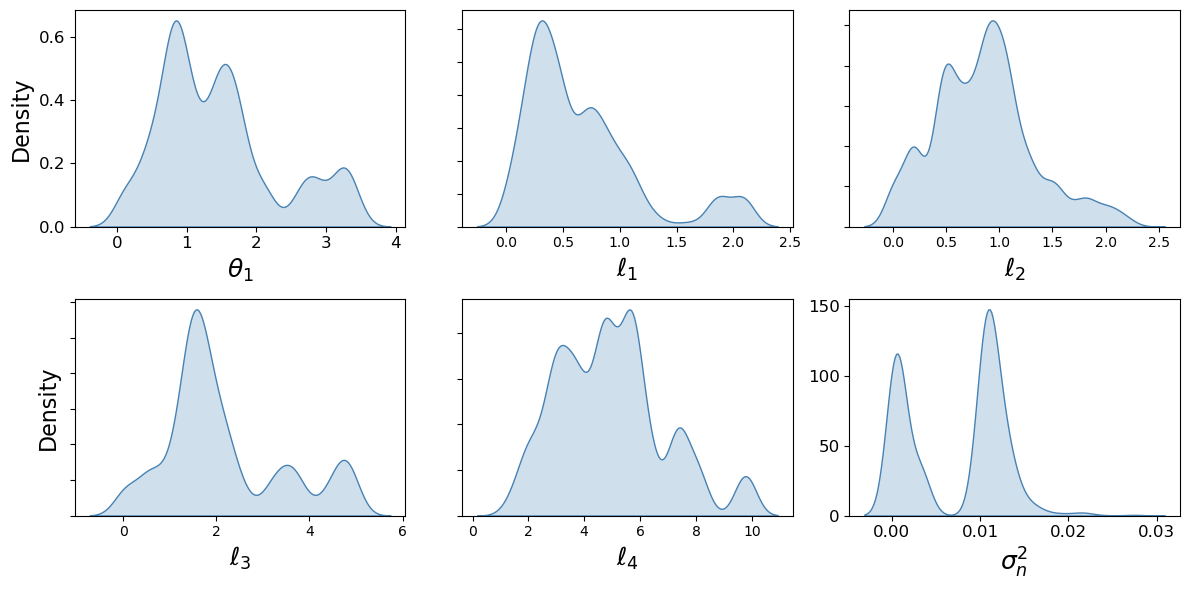

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flattened MCMC samples
flat_samples = sampler.get_chain(discard=burnin, thin=thin,flat=True)
mean_values = np.mean(flat_samples, axis=0)

# Update parameter labels to cover the first and second set of parameters
param_labels = ["$\\theta_1$", "$\\ell_1$", "$\\ell_2$", "$\\ell_3$", "$\\ell_4$","$\\sigma_n^2$"]

# Create a 2x5 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(6):
    sns.kdeplot(flat_samples[:, i], fill=True, ax=axes[i], color='steelblue')
    axes[i].set_xlabel(param_labels[i], fontsize=18)  # Label each subplot with the parameter name

    # Set the Y-axis label only for the leftmost column
    if i % 3 == 0:
        axes[i].set_ylabel("Density", fontsize=16)
    else:
        axes[i].set_ylabel("")  # Remove y-labels from other plots

    # Remove y-tick labels from other plots in the row
    axes[i].set_yticklabels([]) if i % 5 != 0 else axes[i].tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\MCMCWhiteMat", dpi=72, bbox_inches='tight')
plt.show()